# Exploration of the properties of Wordle

The game wordle, find it [here](https://www.powerlanguage.co.uk/wordle/) in which the user has to guess a 5 letter English word. You have 6 chances to guess the word, and each guess must be a valid English word. Each letter of a completed guess turns either green, yellow or gray. Green means the right letter in the right place, yellow means the letter is in the word, gray means the letter is not in the word.

I want to investigate some properties of this game using the notebook. Let's take a look.

I found the actual wordle datasets [here](https://gist.github.com/cfreshman). There are two files. One is everything that you are allowed to guess. The other is the possible answers (they restrict to more commonly known words). This makes things a lot easier, as they are much smaller than the list of all possible English words that I found before.

### Basic Stats

OK. So let's have a look at this data set and find out some simple thing about it. I want to know:

- What is the letter frequency for all letters, which are the most common letters.
- What is the most common letter in each position of the word.
- How often are letters repeated? 2,3,4,5 times, and what are the most frequent repeats.

It's not such a massive data set, so we can safely load everything to memory.

In [1]:
all_answers = [w.strip() for w in open('./data/wordle-answers-alphabetical.txt').readlines()]
all_guesses = [w.strip() for w in open('./data/wordle-allowed-guesses.txt').readlines()]

# For some reason there are only the words in guesses that are not in the answers. So we need to make the combined set.
all_guesses = list(set(all_answers + all_guesses))
len(all_guesses)

12972

In [100]:
from collections import defaultdict
import pandas as pd
from tqdm.notebook import tqdm

<AxesSubplot:>

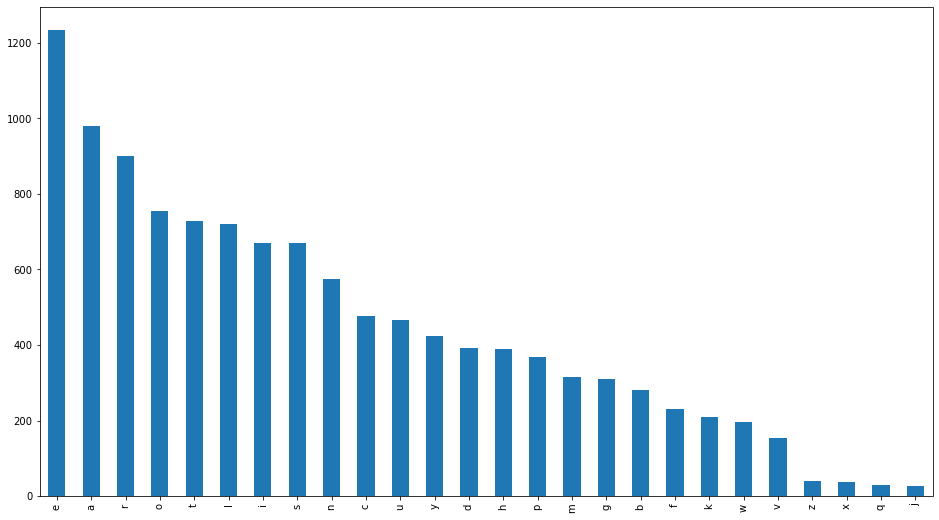

In [3]:
freq_count = defaultdict(int)
for w in all_answers:
    for l in w:
        freq_count[l] += 1
        
freq_series = pd.Series(freq_count)
freq_series.sort_values(ascending=False).plot.bar(figsize=(16,9))

We get the most common letters are 'e', 'a', 'r' 'o' and 't'.

Now what if we do this by position. What are the most common letters in all possible positions?

In [4]:
position_freq = {i: defaultdict(int) for i in range(1, 6)}
for w in all_answers:
    for i, l in enumerate(w):
        position_freq[i+1][l] += 1

Pandas can interpret this dataframe nicely. It gives us the frequency of eery letter in every position.

In [5]:
position_df = pd.DataFrame(position_freq).fillna(0)
position_df.sort_index()

,1,2,3,4,5
a,141.0,304,307,163.0,64.0
b,173.0,16,57,24.0,11.0
c,198.0,40,56,152.0,31.0
d,111.0,20,75,69.0,118.0
e,72.0,242,177,318.0,424.0
f,136.0,8,25,35.0,26.0
g,115.0,12,67,76.0,41.0
h,69.0,144,9,28.0,139.0
i,34.0,202,266,158.0,11.0
j,20.0,2,3,2.0,0.0


In [6]:
from seaborn import heatmap

<AxesSubplot:>

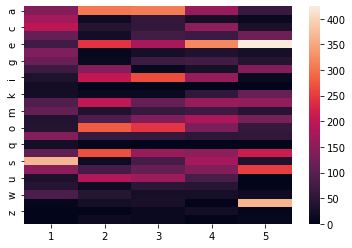

In [7]:
heatmap(position_df)

Which is kind of illuminating, but a bit hard to interpret. We see that 'e' is much more likely to come at the end, and s at the begining.

In [8]:
from matplotlib import pyplot as plt

0 0
0 1
0 2
1 0
1 1


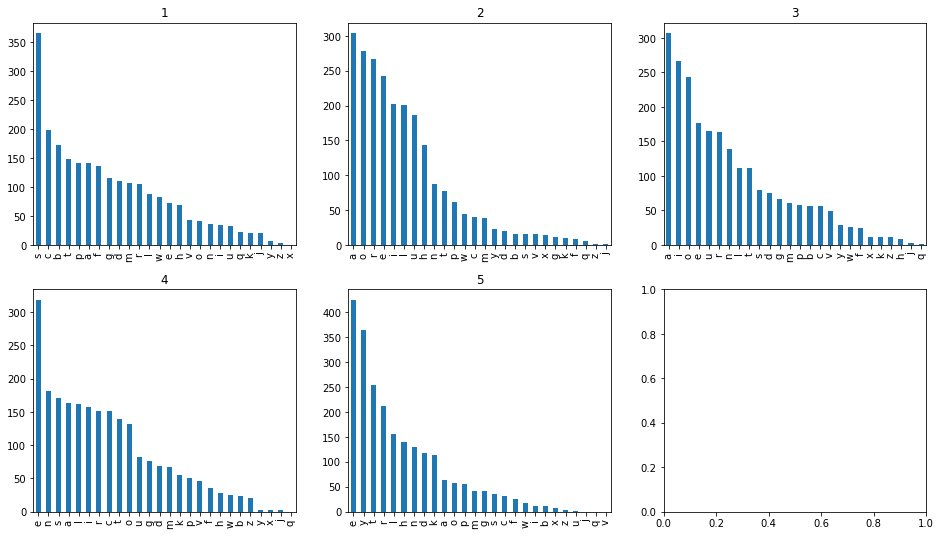

In [9]:
f, axes = plt.subplots(2, 3, figsize=(16, 9))
for i in range(5):
    print(int(i/3), int(i%3))
    ax = axes[int(i/3)][int(i%3)]
    position_df[i+1].sort_values(ascending=False).plot.bar(ax=ax)
    ax.set_title(i + 1)

So this tells us a slightly more nuanced picture. S is by far the most common starting word, a is much more common in second and third place. E is common at the and and also position 4. The position matters a lot. A good first guess might then be 'saaee', unfortunatly this is not a word.

### The First word

This is a common question in the wordle word: what is the best possible first word. How might we actually define the best possible in this case. We want as much information as possible from the first guess. We could try to maximise the number of green letters? Or we could try somehow put a value of yellow letters that is somewhat less than a yellow letter. Let's try first maximising green letters.

First define a function that compares a guess to an answer.

In [10]:
def make_guess(guess, answer):
    """
    Make a guess. Returns 0 for grey, 1 for yellow and 2 for green.
    """
    
    unique_letters = set(answer)

    to_return = []
    for guess_letter, answer_letter in zip(guess, answer):
        if guess_letter == answer_letter:
            to_return.append(2)
        elif guess_letter in unique_letters:
            to_return.append(1)
        else:
            to_return.append(0)

    return to_return

Now make a function that takes a word and compares it to all possible words. It takes an average amount of green. This average green is the score for this word.

In [11]:
import numpy as np

In [12]:
def mean_green(guess):
    """For a given guess return the average number of greens that this word gets as 
    first try.
    """

    return np.mean([make_guess(guess, a).count(2) for a in all_answers])

So now let's try some common first guess and see what they do.

In [13]:
mean_green('spike')

0.5062634989200864

So the word spike averages half a green letter.

This word has a lot of vowels in it, so let's try it:

In [14]:
mean_green('adieu')

0.3222462203023758

It's not such a great guess by this metric.

This guess comes up a lot as it has a lot of the common letters in it.

In [15]:
mean_green('arose')

0.5386609071274298

That is indeed somewhat better.

But as we are using a computer we can find the best mean green start word out of all allowed chances.

In [16]:
mean_green_data = {w : mean_green(w) for w in all_guesses}

In [17]:
pd.Series(mean_green_data).sort_values(ascending=False).head(15)

saree    0.680346
sooey    0.678618
soree    0.669546
saine    0.666091
soare    0.660043
saice    0.653132
sease    0.652268
seare    0.644060
slane    0.639309
seine    0.639309
soole    0.637149
siree    0.636285
seise    0.634557
cooee    0.631965
soote    0.627214
dtype: float64

All of the top guesses start with 's' which is interesting. Note also that the top one is saree, which has a repeat letter. It seems like an intuition not to use repeat letters, so this might not be a good strategy. This is because we are interested in 

Now of course it's not just about the green. We want to assign a weight to yellow as well. Let's give green twice as many points as yellow. There is no profound reason for this yet, but let's try it and see what it gives us.

In [18]:
def sum_score(guess):
    """
    One point for a yellow, two for a green.
    """
    
    return np.mean([sum(make_guess(guess, a)) for a in all_answers])

In [19]:
sum_score('arose')

2.306695464362851

In [20]:
sum_score('adieu')

1.8077753779697625

In [21]:
sum_score('saree')

2.6138228941684667

And try everything, see what our best answer is here.

In [22]:
sum_score_rank = {w: sum_score(w) for w in all_guesses}
pd.Series(sum_score_rank).sort_values(ascending=False).head(15)

saree    2.613823
raree    2.595680
seare    2.577538
areae    2.565443
arere    2.529590
laree    2.506695
resee    2.501944
soree    2.501080
sease    2.491145
serre    2.484233
reate    2.480346
leare    2.470410
erase    2.469546
eerie    2.466955
serer    2.464363
dtype: float64

Now let's try something more sophisticated. There was no real reason to score green twice as much as yellow. What about if we define the best guess as the one that reduces the set of possible answers the most. That is if we make a guess there are a certain number of words left that could be the answer. We want this to be as small as possible on average.

In [23]:
def possible_solutions(guess, result, initial_set):
    """
    Returns the possible solutions that remain after making the guess and getting a certain result.
    """
    
    # Let's simply go through every piece of information one by one and trim the list each time.
    running_possible = initial_set
    for i,r in enumerate(result):
        
        focal_letter = guess[i]

        # This means this letter is not in the word, so get rid of all
        # words that do contain this letter
        if r == 0:
            running_possible = {w for w in running_possible if focal_letter not in w}
            
        # This means that the letter is in the word, but not in that position
        elif r == 1:
            running_possible = {w for w in running_possible if focal_letter in w and w[i] != focal_letter}
            
        # And this means right letter and right place
        elif r == 2:
            running_possible = {w for w in running_possible if w[i] == focal_letter}
            
        else:
            raise ValueError('Something is wrong')
    
    return running_possible

From this we can get a score in terms of how much the word reduces the set of all possible words.

In [24]:
len(possible_solutions('spike', [0,0,1,0,2], all_guesses))

165

In [25]:
def reduction_score(guess):
    scores = []
    for w in all_answers:
        result = make_guess(guess, w)
        new_possibles = possible_solutions(guess, result, all_answers)
        scores.append(len(new_possibles))
    return np.mean(scores)

Now we can try this for all words. I have a feeling this may take some time.

In [26]:
%%timeit
reduction_score('arose')

563 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


About half a second per word. This is going to take a long time, but let's leave it running over night.

In [27]:
reduction_data = {}
best_score = len(all_guesses)
for i, word in enumerate(all_guesses):
    if i%100 == 0:
        print('{:.1f}%'.format(i/len(all_guesses)*100))
    score = reduction_score(word)
    reduction_data[word] = score
    if score < best_score:
        best_score = score
        print('best to date: {}'.format(word))


0.0%
best to date: bassi
best to date: tenes
best to date: lotes
best to date: aures
best to date: saine
0.8%
best to date: realo
1.5%
2.3%
3.1%
3.9%
4.6%
5.4%
6.2%
6.9%
7.7%
8.5%
9.3%
10.0%
10.8%
11.6%
12.3%
13.1%
best to date: arise
13.9%
14.6%
15.4%
16.2%
17.0%
17.7%
18.5%
19.3%
20.0%
20.8%
21.6%
22.4%
23.1%
23.9%
24.7%
25.4%
26.2%
27.0%
27.8%
28.5%
29.3%
30.1%
30.8%
31.6%
32.4%
33.1%
33.9%
34.7%
35.5%
36.2%
37.0%
37.8%
38.5%
39.3%
40.1%
40.9%
41.6%
42.4%
43.2%
43.9%
44.7%
45.5%
46.3%
47.0%
47.8%
48.6%
49.3%
50.1%
50.9%
51.6%
52.4%
53.2%
54.0%
54.7%
55.5%
56.3%
57.0%
57.8%
58.6%
59.4%
60.1%
60.9%
61.7%
62.4%
63.2%
64.0%
64.8%
65.5%
66.3%
67.1%
67.8%
68.6%
69.4%
70.2%
70.9%
71.7%
72.5%
73.2%
74.0%
74.8%
75.5%
76.3%
77.1%
77.9%
78.6%
79.4%
80.2%
80.9%
81.7%
82.5%
83.3%
best to date: raise
84.0%
84.8%
85.6%
86.3%
87.1%
87.9%
88.7%
89.4%
90.2%
91.0%
91.7%
92.5%
93.3%
94.0%
94.8%
95.6%
96.4%
97.1%
97.9%
98.7%
best to date: roate
99.4%


In [28]:
pd.Series(reduction_data).sort_values(ascending=True).head(15)

roate    60.424622
raise    61.000864
raile    61.330886
soare    62.301080
arise    63.725702
irate    63.779266
orate    63.890713
ariel    65.287689
arose    66.021166
raine    67.056156
artel    67.495896
taler    67.736933
ratel    69.843197
aesir    69.882937
arles    69.890713
dtype: float64

Now out of interest what are the worst words to start with?

In [29]:
pd.Series(reduction_data).sort_values(ascending=False).head(10)

immix    969.971922
qajaq    940.134341
jujus    903.488985
jugum    900.945572
gyppy    887.443197
fuffy    882.758963
yukky    880.128294
susus    873.970194
zoppo    873.149460
kudzu    871.554644
dtype: float64

These look like made up words, but I checked on wordle. It seems you really can use them. I like Qajaq.

OK. Well that's the answer for which starting word to use. It's roate! No I don't know what it means either!

The next best ones are:

Raile, soare (this is the one that I've seen mentioned in some blogs, see for example [here](https://theconversation.com/wordle-the-best-word-to-start-the-game-according-to-a-language-researcher-175114), orate (which is the highest ranked word that I actually recognise as a word), ariel, raine, artel, taler. A lot of these words have a pattern of *a*e interestingly. Lots of 'r' and 't'. Although 's' is the most common starting letter in English only a few of these words start with 's'.

Let's try one more strategy just out of curiosity. What if we maximise the worst possible scenario. Formally we could define this in our set reduction technique, so what would be the most words that could still be a possiblity after this guess. Let's try a more heuristic approach in which I ask how many words would be left if I got all grey for that word. The best word is then the one that has the best worst case scenario.

In [30]:
def maximin_score(guess):
    """
    Return the worst case scenario. The word gets all grey. How many choices are left.
    """
    
    return len(possible_solutions(guess, [0, 0, 0, 0, 0], all_answers))

In [31]:
maximin_score('arose')

183

In [32]:
maximin_score('immix')

1429

In [33]:
maxi_min_scores = {w: maximin_score(w) for w in all_guesses}

In [34]:
pd.Series(maxi_min_scores).sort_values(ascending=True).head(10)

aurei    114
uraei    114
auloi    158
aloes    161
adieu    162
aiery    162
ayrie    162
reais    168
aesir    168
raise    168
dtype: int64

Note that this strategy does throw up something different here. Double letters really are a draw back because if they are both grey you get no extra information. The top words are all very vowely. So possibly if you want to minimise your chance of loosing then you should use these, although it is debatable.

For reference let's make a data frame of all the scores.

In [35]:
first_word_scores = pd.DataFrame({'mean_green': mean_green_data,
                                  'weighted_score': sum_score_rank,
                                  'set_reduction': reduction_data,
                                  'maxi_min': maxi_min_scores
                    })

In [36]:
first_word_scores['mean_green_rank'] = first_word_scores.mean_green.rank(ascending=False)
first_word_scores['weighted_score_rank'] = first_word_scores.weighted_score.rank(ascending=False)
first_word_scores['set_reduction_rank'] = first_word_scores.set_reduction.rank(ascending=True)
first_word_scores['maxi_min_rank'] = first_word_scores.maxi_min.rank(ascending=True)

In [37]:
scores = first_word_scores[[c for c in first_word_scores.columns if 'rank' not in c]]
ranks = first_word_scores[[c for c in first_word_scores.columns if 'rank' in c]]

In [38]:
first_word_scores.sort_values('set_reduction_rank').head(20)

,mean_green,weighted_score,set_reduction,maxi_min,mean_green_rank,weighted_score_rank,set_reduction_rank,maxi_min_rank
roate,0.541685,2.330886,60.424622,195,242.0,54.0,1.0,44.0
raise,0.548596,2.305400,61.000864,168,200.0,73.0,2.0,10.0
raile,0.544708,2.314471,61.330886,173,225.5,68.0,3.0,14.0
soare,0.660043,2.428078,62.301080,183,5.0,20.0,4.0,25.5
arise,0.548164,2.304968,63.725702,168,204.0,74.0,5.0,10.0
irate,0.505832,2.283801,63.779266,194,614.5,98.0,6.0,39.5
orate,0.508855,2.298056,63.890713,195,578.5,85.0,7.0,44.0
ariel,0.495896,2.265659,65.287689,173,779.0,123.0,8.0,14.0
arose,0.538661,2.306695,66.021166,183,269.5,72.0,9.0,25.5
raine,0.553348,2.280778,67.056156,195,172.0,102.5,10.0,44.0


In [39]:
scores.corr()

,mean_green,weighted_score,set_reduction,maxi_min
mean_green,1.000000,0.674070,-0.333750,-0.287065
weighted_score,0.674070,1.000000,-0.626072,-0.630664
set_reduction,-0.333750,-0.626072,1.000000,0.968908
maxi_min,-0.287065,-0.630664,0.968908,1.000000


In [40]:
ranks.corr()

,mean_green_rank,weighted_score_rank,set_reduction_rank,maxi_min_rank
mean_green_rank,1.000000,0.650234,0.354107,0.281813
weighted_score_rank,0.650234,1.000000,0.665924,0.643265
set_reduction_rank,0.354107,0.665924,1.000000,0.969412
maxi_min_rank,0.281813,0.643265,0.969412,1.000000


In [41]:
from seaborn import pairplot

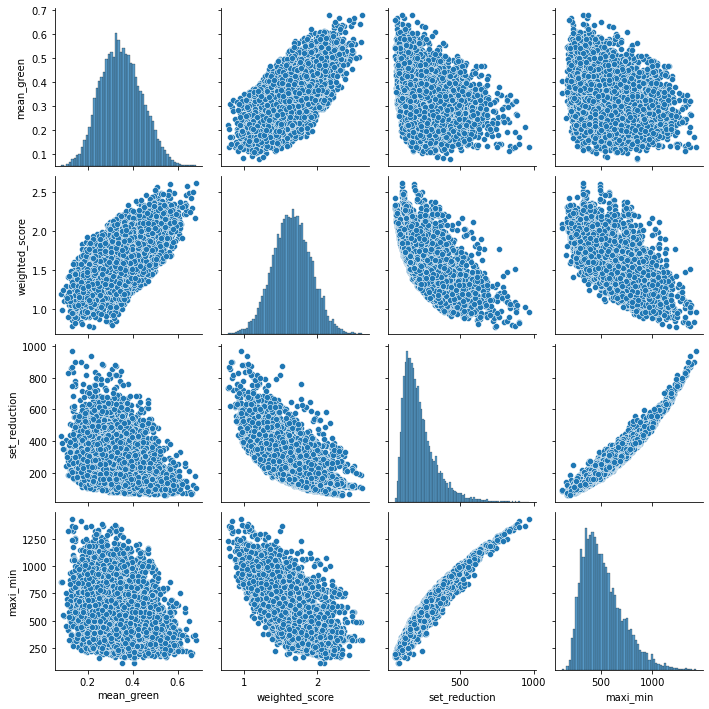

In [42]:
pairplot(scores)

So visually there is quite a bit of correlation between our ranking methods. This is expected. Set reduction and maxi-min correlate the closest. Mean_green and weighted score seem to correlate well. These methods involve the same kind of logic, so it's not too surprising.

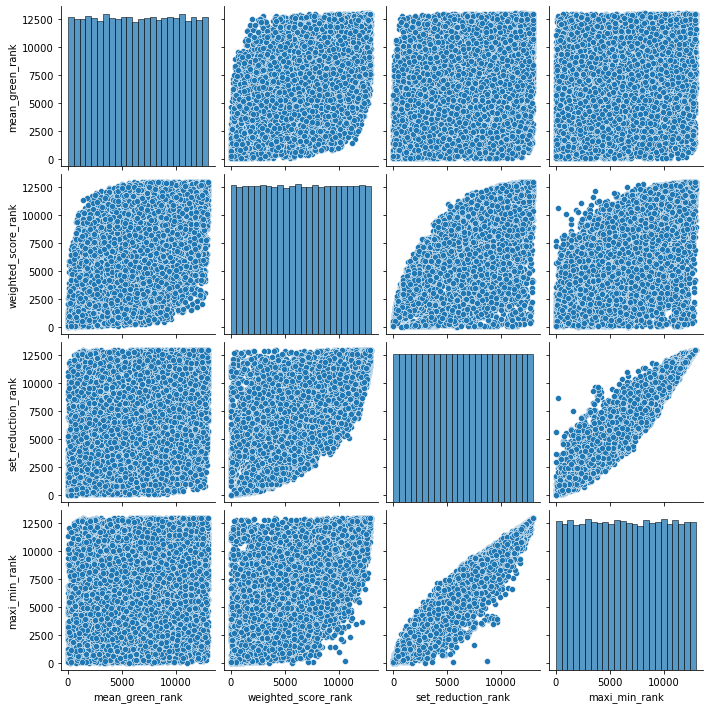

In [43]:
pairplot(ranks)

### The Game

Let's code a basic version of the game. I want the computer to play the game, so no user interface is really necessary.

Note that using just the list of 2000 makes it a bit too easy. So I'm going to assume the answer is choosen from the list of all possible guesses just to give the computer a chance actually to fail.

In [44]:
import numpy as np

In [45]:
class Wordle:
    
    def __init__(self):
        self.tries_left = 6
        self.answer = self._random_word()
        self.unique_letters = set(self.answer)
        
    def _random_word(self):
        return np.random.choice(all_guesses)
    
    def make_guess(self, word):
        """
        Make a guess. Returns 0 for grey, 1 for yellow and 2 for green.
        """ 
        
        if self.tries_left <= 0:
            raise ValueError('Out of tries')
        
        if len(word) != 5:
            raise ValueError('Must be a 5 letter word')
        if word not in all_guesses:
            raise ValueError('Word {} not a valid word'.format(word))

        to_return = []
        for guess_letter, answer_letter in zip(word, self.answer):
            if guess_letter == answer_letter:
                to_return.append(2)
            elif guess_letter in self.unique_letters:
                to_return.append(1)
            else:
                to_return.append(0)
                
        self.tries_left -= 1
        return to_return

Now I want to try a simple strategy. The strategy simply chooses randomly from all words that the answer possibly could be. My question is how often does it succeed.

In [46]:
def play_naive(verbose=False):
    """Plays the relatively naive strategy of guessing randomly from everything that the word
    could be.
    """
    
    wordle = Wordle()
    all_possible = all_guesses
    score = 1
    for i in range(6):
        guess = np.random.choice(list(all_possible))
        result = wordle.make_guess(guess)
        if result == [2, 2, 2, 2, 2]:
            if verbose:
                print('you won with {}'.format(guess))
            return True, score
        else:
            score += 1
        all_possible = possible_solutions(guess, result, all_possible)
        if verbose:
            print(guess)
            print(result)
            print('{} possible words left'.format(len(all_possible)))
            print('-----------')
    # If it gets to here you've lost
    return False, 12

In [47]:
play_naive(True)

aedes
[1, 0, 0, 0, 1]
421 possible words left
-----------
nashi
[0, 1, 1, 0, 0]
127 possible words left
-----------
splay
[2, 2, 0, 1, 2]
1 possible words left
-----------
you won with spacy


(True, 4)

In [48]:
wins = []
scores = []
repeats = 10000
for i in range(repeats):
    won, score = play_naive()
    wins.append(won)
    scores.append(score)

In [49]:
wins.count(False)/10000

0.1736

So it does actually loose relatively often. That's interesting.

In [50]:
distribution = {i: scores.count(i) for i in range(1, 7)}

<AxesSubplot:>

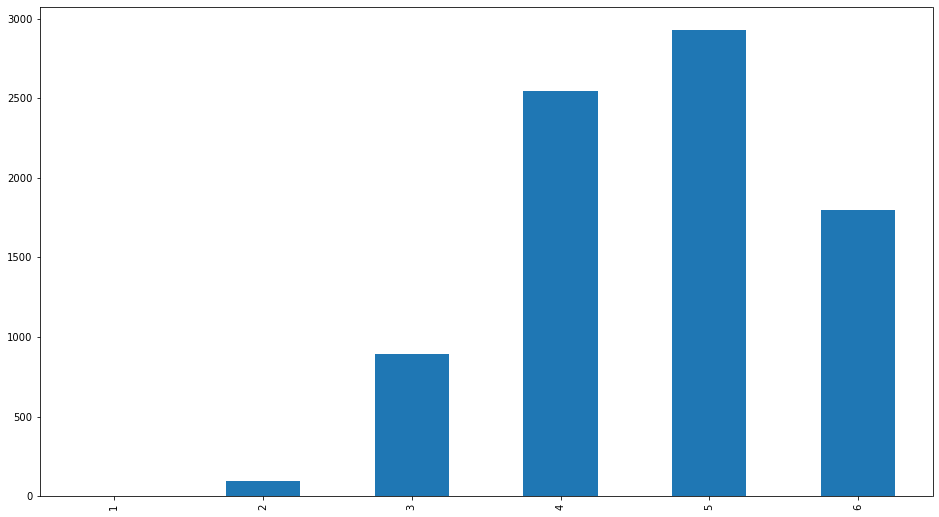

In [51]:
pd.Series(distribution).plot.bar(figsize=(16, 9))

In [52]:
distribution

{1: 1, 2: 95, 3: 894, 4: 2548, 5: 2925, 6: 1801}

How does it do? How should we evaluate the answer in the end. Are we simply trying to get it and fail as seldom as possible, or are we trying to get a low score. How much worse is a failure compared to a low score.

Try some other methods.

1. Do what we have above, but pick a different start word. One that we found to be good from the previous selection.
2. Pick the highest ranking word which the solution could be, based on the first word rankings. Is this better than the one above?

In [53]:
def naive_with_first(first_guess, verbose=False):
    """Plays the relatively naive strategy of guessing randomly from everything that the word
    could be.
    """
    
    wordle = Wordle()
    all_possible = all_guesses
    score = 1
    for i in range(6):
        if i ==0:
            guess = first_guess
        else:
            guess = np.random.choice(list(all_possible))
        result = wordle.make_guess(guess)
        if result == [2, 2, 2, 2, 2]:
            if verbose:
                print('you won with {}'.format(guess))
            return True, score
        else:
            score += 1
        all_possible = possible_solutions(guess, result, all_possible)
        if verbose:
            print(guess)
            print(result)
            print('{} possible words left'.format(len(all_possible)))
            print('-----------')
    # If it gets to here you've lost
    # I've decided that loosing is twice as bad as getting it on the last try.
    # This is arbitrary
    return False, 12

And try the best first word from our set-reduction method.

In [101]:
def evaluate(fn, repeats, *args, **kwargs):
    
    wins = []
    scores = []
    for i in tqdm(range(repeats)):
        won, score = fn(*args, **kwargs)
        wins.append(won)
        scores.append(score)
    loss_frac = wins.count(False)/10000
    print('Loss Fraction: {:.2f}%'.format(loss_frac*100))
    print('mean score: {:.4f}'.format(np.mean(scores)))
    dist = {i: scores.count(i) for i in range(1, 7)}
    pd.Series(dist).plot.bar()
    return loss_frac, dist

In [55]:
best_first = first_word_scores.sort_values('set_reduction').index[0]

In [56]:
naive_with_first(best_first, True)

roate
[0, 1, 0, 0, 0]
422 possible words left
-----------
skios
[0, 0, 1, 1, 0]
43 possible words left
-----------
globi
[0, 0, 1, 1, 1]
2 possible words left
-----------
biffo
[2, 2, 0, 0, 2]
1 possible words left
-----------
you won with bizzo


(True, 5)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss Fraction: 16.75%
mean score: 5.7807


(0.1675, {1: 0, 2: 120, 3: 1199, 4: 2741, 5: 2684, 6: 1581})

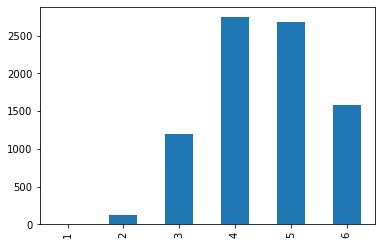

In [102]:
evaluate(naive_with_first, 10000, best_first)

And compare my previous version with this as we did before.

Loss Fraction: 17.16%
mean score: 5.9090


(0.1716, {1: 1, 2: 105, 3: 931, 4: 2564, 5: 2860, 6: 1823})

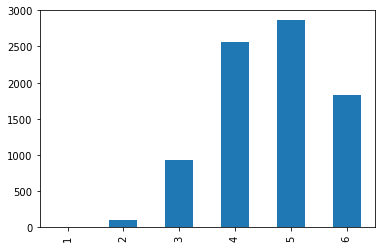

In [58]:
evaluate(play_naive, 10000)

And try it with the best maxi-min.

In [59]:
best_maxi_min = ranks.sort_values('maxi_min_rank').index[0]
best_maxi_min

'aurei'

Loss Fraction: 18.45%
mean score: 5.9525


(0.1845, {1: 0, 2: 121, 3: 1092, 4: 2598, 5: 2589, 6: 1755})

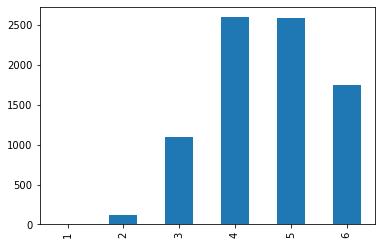

In [60]:
evaluate(naive_with_first, 10000, best_maxi_min)

And the more sophisticated version. Take the highest ranked word that is a possibility still.

In [61]:
word_ranks = ranks.set_reduction_rank.to_dict()

In [62]:
some_words = {'light', 'adieu', 'arose'}

In [63]:
len(set(all_answers).union(all_guesses))

12972

In [64]:
word_ranks = [(k,v) for k,v in ranks.set_reduction_rank.to_dict().items()]

In [65]:
def next_best(verbose=False):
    
    words_series = ranks.set_reduction_rank
    wordle = Wordle()
    all_possible = all_guesses
    score = 1
    for i in range(6):

        # Pick the highest ranked guess that is still possible.
        guess = words_series.sort_values().index[0]
        result = wordle.make_guess(guess)
        if result == [2, 2, 2, 2, 2]:
            if verbose:
                print('you won with {}'.format(guess))
            return True, score
        else:
            score += 1
        all_possible = possible_solutions(guess, result, all_possible)
        words_series = words_series.loc[all_possible]
        if verbose:
            print(guess)
            print(result)
            print('{} possible words left'.format(len(all_possible)))
            print('-----------')
    # If it gets to here you've lost
    # I've decided that loosing is twice as bad as getting it on the last try.
    # This is arbitrary
    return False, 12


In [66]:
next_best(True)

roate
[1, 0, 2, 1, 0]
63 possible words left
-----------
trail
[1, 1, 2, 0, 0]
13 possible words left
-----------
starn
[2, 2, 2, 2, 0]
4 possible words left
-----------
you won with stark


(True, 4)

Loss Fraction: 14.26%
mean score: 5.4527


(0.1426, {1: 0, 2: 141, 3: 1534, 4: 3231, 5: 2401, 6: 1267})

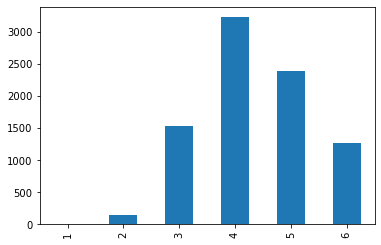

In [67]:
evaluate(next_best, 10000)

### Best second word

Take the best first word and find all possible outcomes from this guess. In principle there are 3*5 possible outcomes, but in reality some of these are impossible. For instance the result [2,2,2,2,1] is impossible, as is any outcome with 4 2s and a 1. The outcome of 3 2s and 2 1s is not impossible, but then then there is only one answer.

I want for every possible outcome the next second guess.

This may also help to answer the question of whether it is ever a good idea to guess something that is not actually a possible solution.

Let's first see what kind of responses for the best initial guess there are. It may be that some simply don't show up.

In [68]:
all_possible = set()

In [69]:
make_guess('roate', 'spike')

[0, 0, 0, 0, 2]

In [70]:
'spike' in all_guesses

True

In [71]:
word

'jivey'

In [72]:
word = best_first
all_possible = set()
for answer in all_guesses:
    response = tuple(make_guess(word, answer))
    all_possible.add(response)

In [73]:
len(all_possible)

177

So there are a few responses that don't actually ever occur. Of course these contain [2,2,2,2,1] and variations, but it looks like a few more as well.

Now we want to do something a bit more complicated. For every possible response to the first answer, find out what the best second answer would be. We have to score all the other words based on what remains in the set.

In [74]:
def reduction_score(guess, word_list):
    scores = []
    for w in word_list:
        result = make_guess(guess, w)
        new_possibles = possible_solutions(guess, result, word_list)
        scores.append(len(new_possibles))
    return np.mean(scores)

In [82]:
def best_guess(remaining_possibiles):
    for i,guess in enumerate(all_guesses):
        score = reduction_score(guess, remaining_possibiles)
        if i == 0 or score < best_yet:
            best_guess = guess
            best_yet = score
        # A slightly better version could at this point prefer a choice in which
        # is in the list of possible answers.
    return best_guess, score

In [83]:
best_second_data = []
word = best_first
for response in all_possible:
    
    print(response)

    data = {'first_word': word,
            'response': response
           }

    # Now get the set of remaining words
    remaining_possibles = possible_solutions(word, response, all_answers)
    
    data['possible_at_round2'] = len(remaining_possibles)
    
    if len(remaining_possibles) == 1:
        data['best_second_guess'] = remaining_possibles.pop()
        data['best_guess_is_possible'] = True
        best_second_data.append(data)
        continue

    best_second, best_score = best_guess(remaining_possibles)
    
    data['best_second_guess'] = best_second
    data['best_guess_is_possible'] = best_second in remaining_possibles
    data['second_score'] = best_score
    
    best_second_data.append(data)


(0, 1, 1, 2, 0)
(1, 0, 2, 0, 1)
(2, 0, 0, 2, 0)
(0, 0, 1, 0, 0)
(1, 1, 2, 1, 0)
(2, 0, 1, 0, 0)
(0, 1, 1, 1, 1)
(0, 2, 1, 1, 0)
(0, 2, 1, 0, 2)
(1, 1, 1, 1, 1)
(1, 1, 0, 0, 0)
(0, 2, 0, 0, 1)
(1, 0, 0, 0, 1)
(0, 1, 1, 0, 2)
(0, 1, 1, 2, 2)
(1, 2, 0, 1, 1)
(2, 0, 0, 2, 2)
(1, 0, 1, 0, 1)
(1, 1, 0, 2, 0)
(2, 0, 1, 0, 2)
(2, 0, 1, 1, 1)
(0, 2, 2, 2, 0)
(2, 0, 2, 1, 0)
(1, 1, 0, 0, 2)
(1, 1, 0, 1, 1)
(0, 1, 2, 2, 0)
(0, 2, 0, 2, 0)
(1, 0, 1, 1, 1)
(1, 1, 0, 2, 2)
(2, 0, 1, 2, 1)
(0, 2, 2, 2, 2)
(0, 0, 2, 0, 1)
(0, 2, 0, 1, 1)
(0, 0, 2, 1, 0)
(2, 2, 2, 1, 0)
(0, 0, 0, 0, 1)
(1, 0, 2, 1, 0)
(2, 0, 2, 2, 1)
(1, 2, 1, 0, 0)
(0, 1, 0, 2, 1)
(0, 1, 2, 2, 2)
(2, 1, 0, 2, 1)
(0, 2, 0, 2, 2)
(2, 0, 0, 0, 0)
(2, 1, 0, 0, 1)
(1, 1, 1, 2, 0)
(2, 0, 0, 1, 1)
(2, 2, 0, 1, 0)
(0, 0, 2, 1, 2)
(0, 0, 0, 2, 0)
(1, 0, 0, 1, 0)
(0, 1, 2, 0, 1)
(1, 0, 2, 2, 0)
(1, 0, 2, 1, 2)
(1, 2, 1, 1, 0)
(1, 2, 1, 0, 2)
(0, 0, 1, 1, 1)
(0, 0, 1, 2, 0)
(1, 2, 2, 1, 0)
(0, 0, 0, 1, 1)
(0, 0, 1, 0, 2)
(0, 1, 1, 1, 0)
(2, 1, 1

In [84]:
best_second_df = pd.DataFrame(best_second_data)

In [85]:
best_second_df

,first_word,response,possible_at_round2,best_second_guess,best_guess_is_possible,second_score
0,roate,"(0, 1, 1, 2, 0)",1,quota,True,NaN
1,roate,"(1, 0, 2, 0, 1)",6,lobby,False,3.000000
2,roate,"(2, 0, 0, 2, 0)",1,rusty,True,NaN
3,roate,"(0, 0, 1, 0, 0)",112,lysin,False,26.464286
4,roate,"(1, 1, 2, 1, 0)",0,bassi,False,NaN
...,...,...,...,...,...,...
172,roate,"(0, 2, 1, 0, 0)",16,liman,False,9.375000
173,roate,"(0, 0, 0, 2, 1)",12,plesh,False,4.000000
174,roate,"(1, 2, 1, 2, 0)",1,aorta,True,NaN
175,roate,"(2, 2, 0, 2, 2)",1,route,True,NaN


In [86]:
best_second_df.groupby('best_guess_is_possible').count()

,first_word,response,possible_at_round2,best_second_guess,second_score
best_guess_is_possible,,,,,
False,151,151,151,151,100
True,26,26,26,26,3


In [87]:
second_guess_map = best_second_df.set_index('response').best_second_guess.to_dict()

So that suggests that making a guess that is possible on the second round is actually very often not the best thing to do.

Now let's try out this information. Set a strategy that plays the best guess first always, then it simply looks up the second best guess based on the response. From then on it tries the highest ranked possible solution, to make the comparison fair with the next best solution.

In [88]:
def first_second(verbose=False):

    words_series = ranks.set_reduction_rank
    wordle = Wordle()
    all_possible = all_guesses
    score = 1
    for i in range(6):
        
        if i == 0:
            guess = best_first
        elif i == 1:
            guess = second_guess_map[tuple(result)]
        else:
            # Pick the highest ranked guess that is still possible.
            guess = words_series.sort_values().index[0]
        result = wordle.make_guess(guess)
        if result == [2, 2, 2, 2, 2]:
            if verbose:
                print('you won with {}'.format(guess))
            return True, score
        else:
            score += 1
        all_possible = possible_solutions(guess, result, all_possible)
        words_series = words_series.loc[all_possible]
        if verbose:
            print(guess)
            print(result)
            print('{} possible words left'.format(len(all_possible)))
            print('-----------')
    # If it gets to here you've lost
    # I've decided that loosing is twice as bad as getting it on the last try.
    # This is arbitrary
    return False, 12

In [89]:
first_second(verbose=True)

roate
[1, 0, 0, 0, 2]
136 possible words left
-----------
piums
[0, 2, 0, 0, 1]
2 possible words left
-----------
you won with birse


(True, 3)

Loss Fraction: 10.33%
mean score: 5.1130


(0.1033, {1: 0, 2: 16, 3: 1867, 4: 3497, 5: 2409, 6: 1178})

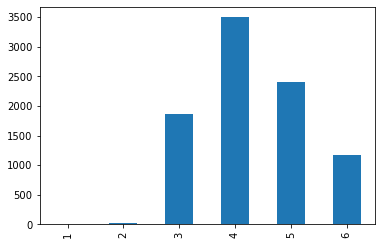

In [90]:
evaluate(first_second, 10000)

That did a fair bit better right! It still sometimes fails.

### Optimal Solution

Each time choose the solution that has the minimum expected possible set time. Obviously at some point it needs to make a guess. Let's only make the guess if the set is one, or if we are on the final round.

In [91]:
def set_reducer(verbose=False):

    words_series = ranks.set_reduction_rank
    wordle = Wordle()
    all_possible = all_guesses
    score = 1
    for i in range(6):

        # One and two are the same, it's just that we've cached the results.
        if i == 0:
            guess = best_first
        elif i == 1:
            guess = second_guess_map[tuple(result)]
        # Maybe we want a clause here that if we are on the last try we should
        # always make a possible guess?
        else:
            if len(all_possible) <= 2:
                guess = list(all_possible)[0]
            else:
                guess, _ = best_guess(all_possible)
        result = wordle.make_guess(guess)
        if result == [2, 2, 2, 2, 2]:
            if verbose:
                print('you won with {}'.format(guess))
            return True, score
        else:
            score += 1
        all_possible = possible_solutions(guess, result, all_possible)
        words_series = words_series.loc[all_possible]
        if verbose:
            print(guess)
            print(result)
            print('{} possible words left'.format(len(all_possible)))
            print('-----------')
    # If it gets to here you've lost
    # I've decided that loosing is twice as bad as getting it on the last try.
    # This is arbitrary
    return False, 12

In [97]:
set_reducer(verbose=True)

roate
[1, 0, 1, 0, 0]
383 possible words left
-----------
mincy
[0, 0, 0, 0, 0]
108 possible words left
-----------
bluds
[0, 0, 0, 0, 2]
17 possible words left
-----------
pawks
[0, 2, 0, 0, 2]
2 possible words left
-----------
you won with zarfs


(True, 5)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss Fraction: 0.01%
mean score: 4.2960


(0.0001, {1: 0, 2: 4, 3: 101, 4: 546, 5: 299, 6: 49})

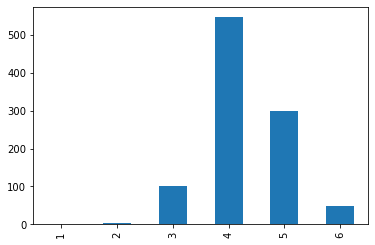

In [103]:
evaluate(set_reducer, 1000)

It hardly ever looses man! That is pretty good. In fact it lost only once out of 100. Of course we have to run for longer to get a better idea.

In [104]:
second_guess_map[(0,0,1,1,1)]

'splat'

And if you're feeling really boring you can use this techinque to solve the problem on the website.

A note on the optimal solution. The optimal solution would trade off gaining information with having a chance of being right. As we can see sometimes the guess that gives you the most information is not in the set of possible solutions. There might be another guess which is almost as good that is in the set of possible solutions, and it might be at some point better to play this. Exactly how to formalise this is quite difficult, but in general when there are many solutions left it plays to gain information. If there are not many solutions left then guessing becomes a better bet.